# Covid19 Data Analysis

#### Overview
...

In [10]:
import os
import re
import json
from datetime import datetime
from math import ceil
from io import StringIO
from glob import glob
from pprint import pprint
# aws
#import boto3
# quant analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
# import sklearn.datasets
import scipy.stats
# data viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import bokeh

In [11]:
def CONFIG():
    """"""
    pid = 'analysis-covid19'
    now = datetime.now()
    cwd = os.getcwd()
    data = os.path.join(cwd,'out')
    
    cfg = {
        'out': data,
        'covid': os.path.join(data,'covid'),
        'demo': os.path.join(data,'demo'),
        'files': glob(os.path.join(data,'*','*.parquet.gzip'),recursive=True),
    }
    
    return cfg

In [12]:
class Covid19: # naming convention: GoodName
    """
    Class for retrival, storage, and manipulation
      of Covid19 data.
    """
    
    __slots__ = ('fpath','dataframe',)
    
    def __init__(self,fpath):
        self.fpath = fpath
        self.dataframe = _load()
        self.is_clean = 0
        self.is_processed = 0
    
    @staticmethod # static methods - does it make sense to call a class method
    # EVEN BEFORE a class has been created? e.g. metric conversion info
    def define():
        return '\
            Coronavirus disease 2019 (COVID-19) \
            is an infectious disease caused by severe \
            acute respiratory syndrome coronavirus 2 \
            (SARS-CoV-2).[10] It was first identified in \
            December 2019 in Wuhan, Hubei, China, and has \
            resulted in an ongoing pandemic.\
        '
    
    def __repr__(self):
        return f'Covid19({self.fpath!r})'
    def __str__(self):
        return f'Covid19 dataset - {self.fpath}'
    def _load(self):
        return pd.read_parquet(self.fpath,header=0)
    
    # instance method
    def clean(self):
        try:
            df = self.dataframe
            # ...
            self.dataframe = df
            self.is_clean = 1
        except:
            raise
    
    # instance method
    def process(self):
        try:
            assert self.is_clean==1
            df = self.dataframe
            # ...
            self.dataframe = df
            self.is_processed = 1
        except AssertionError:
            self.clean()
            self.process()
        except:
            raise
    

In [13]:
def SUMMARY(series, sample=2):
    """"""
    unique = series.unique()
    values = series.dropna()
    dtype = str(type(values[0])).split('\'')[1]
    
    return {
        'dtype': dtype, # c.dtypes
        'sample': series.sample(n=sample).to_list(), # .sample(n=ceil(series.shape[0]*sample)),
        'countA': series.shape[0],
        'countD': len(unique),
        'countV': series.count(),
        'countNaN': series.isna().sum(),
        'min': min(values),
        'mode': series.mode().to_list(),
        'max': max(values),
        'median': series.median() if dtype!='str' else None,
        'mean': round(series.mean(),2) if dtype!='str' else None,
        'std': round(series.std(),2) if dtype!='str' else None,
    }

In [14]:
def REGRESS():
    """"""
    df = data['jhu-csse-dly-us'].dropna()
    x = df.loc[:,['CONFIRMED','DEATHS']]
    y = df['MORTALITY_RATE']
    mod = sm.OLS(y,x).fit()

    return mod.summary()

In [15]:
def PLOT(df,xaxis,yaxis,split):
    """"""
    sns.set_theme(style='ticks')
    return sns.lmplot(
        x=xaxis,y=yaxis,
        data=df,hue=split,
#         palette='husl',
    ) 

In [16]:
def PREP(df):
    """"""
    # dates
    date_field = 'DATA_DT'
    date_format = '%Y-%m-%d'
    df.date_field = df.date_field.apply(lambda x: x.strftime(date_format))
    # other...
    
    return df

In [ ]:
# IVs: county population (COVID-JHU-FIPS), county geography (), covid19 tests per 1k pop (COVID-JHU-DLY-US - state level, (POS+NEG) tests per 1k persons)
# DV: covid19 deaths by county (COVID-JHU-FIPS)

In [37]:
pop = data['covid-jhu-fips'][['POPULATION','FIPS']]
cases = data['covid-jhu-ts-cases'] # ts data needs to be unpivoted to make pop adjustment
geo = data['demo-cb-geo'][['ALAND','GEOID']]
pov = data['demo-cb-pov'][['ALL AGES IN POVERTY PERCENT','YEAR','COUNTY ID']]
test = data['covid-jhu-dly-us'][['TESTING_RATE','PROVINCE_STATE']] # only state level available
death = data['covid-jhu-ts-deaths'] # ts data needs to be unpivoted to join to IVs and make pop adjustment

In [36]:
if __name__=='__main__':
    CFG = CONFIG()
    
    data = {}
    for file in CFG['files']:
        fname = os.path.basename(file).split('.')[0]
        data[fname] = pd.read_parquet(file)
#     data.keys()

#     PLOT(data['jhu-csse-dly-us'],'DATA_DT','CONFIRMED','PROVINCE_STATE')

In [87]:
pprint(SUMMARY(df.CONFIRMED))

{'countA': 9994,
 'countD': 8383,
 'countNaN': 0,
 'countV': 9994,
 'dtype': 'numpy.int64',
 'max': 819115,
 'mean': 60258.32,
 'median': 20112.0,
 'min': 0,
 'mode': [0],
 'sample': [3346, 47636],
 'std': 109602.43}


In [81]:
states = ['Virginia','Florida','New York','California','Texas']
df = data['covid-jhu-dly-us']
df.PROVINCE_STATE = df.loc[df.PROVINCE_STATE.isin(states)]

<AxesSubplot:title={'center':'Confirmed Cases over Time'}, xlabel='Date', ylabel='Confirmed Cases'>

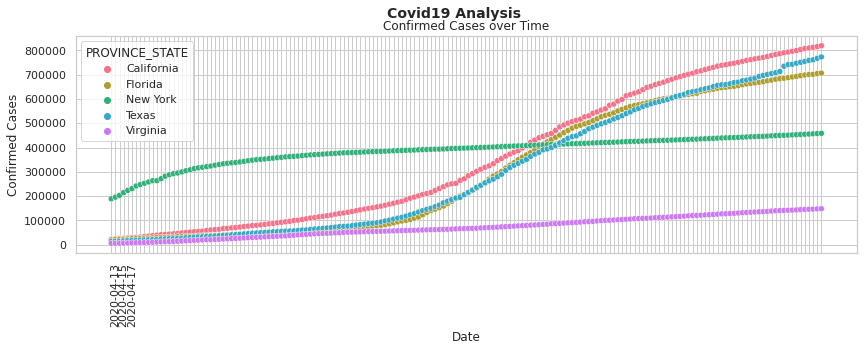

In [83]:
# init
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,4))
# figure
fig.suptitle('Covid19 Analysis', fontsize=14, fontweight='bold')
# axis
# ax.set_xlim([-10000, 140000])
# ax.legend().set_visible(True)
# formatter = plt.FuncFormatter(fmt_function) # def fmt_function(x, position) ...
# ax.xaxis.set_major_formatter(plt.FuncFormatter())
ax.set(title='Confirmed Cases over Time', xlabel='Date', ylabel='Confirmed Cases')
# ax.axhline(y=df.CONFIRMED.mean(), xmin=0, xmax=1, color='r', label='Average', linestyle='--', linewidth=1)

# sns.despine(f, left=True, bottom=True)
for label in ax.get_xaxis().get_ticklabels()[:]:
    print(label)
    label.set_visible(False)
plt.xticks(rotation=90)
# fig.autofmt_xdate()
# seaborn
plt.style.use('ggplot')
sns.set_theme(style='whitegrid')
sns.scatterplot(
    x='DATA_DT',
    y='CONFIRMED',
    data=df,
    hue='PROVINCE_STATE',
    palette='husl',legend='auto',
#     scatter_kws={"s": 50, "alpha": 1},
    ax=ax,
)
# fig.savefig('covid19.svg', transparent=False, dpi=80, bbox_inches='tight')

In [ ]:
import random

In [158]:
### data ###
ages_x = [i for i in range(25,36,1)]
dev_y = [i*random.randint(190,210) for i in ages_x]
py_dev_y = [i*random.randint(220,240) for i in ages_x]
js_dev_y = [i*random.randint(200,220) for i in ages_x]
x_indexes = np.arange(len(ages_x))
### df ###
df = pd.DataFrame({'ages': ages_x, 'all_devs': dev_y, 'py_dev': py_dev_y, 'js_dev': js_dev_y})
df.columns = map(lambda x: x.lower(), df.columns)

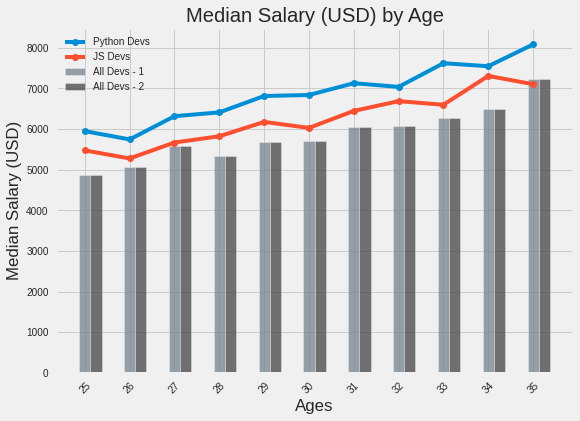

In [172]:
### cfg ###
bar_width = 0.25
### init ###
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False) # __ -> (ax1,ax2)
### labels, formatting ###
plt.grid(True)
plt.tight_layout()
plt.style.use('fivethirtyeight') # ggplot, seaborn, fivethirtyeight, tableau-colorblind10, grayscale
plt.xticks(ticks=x_indexes,labels=ages_x)
plt.xticks(rotation=45)
### axis ###
ax.set_xlabel('Ages')
ax.set_ylabel('Median Salary (USD)')
ax.set_title('Median Salary (USD) by Age')
### plot ###
ax.plot(x_indexes,py_dev_y,marker='o',label='Python Devs') # linestyle='--',marker='.'
ax.plot(x_indexes,js_dev_y,marker='o',label='JS Devs')
ax.bar(x_indexes,dev_y,color='#75838f',width=bar_width,alpha=0.75,label='All Devs - 1') # lines are plotted in order of code, can overlap
ax.bar(x_indexes+bar_width,dev_y,color='#444444',width=bar_width,alpha=0.75,label='All Devs - 2') # lines are plotted in order of code, can overlap
ax.legend()

In [144]:
fig.savefig('fig.svg')

In [ ]:
from matplotlib import dates as plt_dates
### dates ###
plt.plot_date(dates,y,linestyle='solid')
fig.autofmt_xdate()
date_format = mplt_dates.DateFormatter('%Y-%m-%d') # %b, %d %Y
plt.gca().xaxis.set_major_formatter(date_format)